In [9]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import eye_array, diags_array
from pymrm import construct_grad, construct_div, newton, non_uniform_grid, numjac_local, clip_approach

In [10]:
class WeiszHicksCoupled:
    def __init__(self, phi, beta, gamma):
        self.gamma = gamma
        self.beta = beta
        self.k_0 = phi*phi
        self.N = 30
        self.bc = {'a':[1,0],'b':[0,1], 'd':[0,1]} 
        self.dt = np.infty
        #self.r_f = np.linspace(0,self.R,self.N+1)
        dr_large = 0.1
        self.r_f = non_uniform_grid(0, 1.0, self.N+1, dr_large, 0.75)
        self.r_c = 0.5*(self.r_f[0:-1]+self.r_f[1:])
        self.init_field()
        self.init_Jac()
        self.freq_out = 10
    
    def name(self):
        return 'Weisz and Hicks coupled method'
    
    def init_field(self, c0=0.0, T0=1.0):
        self.c = np.full((self.N,2), [[c0, T0]], dtype='float')
    
    def init_Jac(self):
        Grad, grad_bc = construct_grad(self.c.shape, self.r_f, self.r_c, self.bc, axis = 0)
        self.Div = construct_div(self.c.shape, self.r_f, nu=2, axis = 0)        
        self.Flux = -Grad
        self.flux_bc = -grad_bc
        Jac_accum = (1.0/self.dt)*eye_array(self.N*2,format='csc')
        self.g_const = self.Div @ self.flux_bc
        self.Jac_const = Jac_accum + self.Div@self.Flux

    def set_phi(self, phi):
        self.k_0 = phi*phi
    
    def reaction(self, c):
        T = c[:,[1]]
        r = self.k_0*np.exp(self.gamma*(1.0-1.0/T))*c[:,[0]]*np.array([[-1.0,self.beta]])
        return r
        
    def construct_Jac(self, c, c_old):
        g_react, Jac_react = numjac_local(self.reaction, c, axis=1)
        g = self.g_const + self.Jac_const @ c.reshape((-1,1)) - c_old.reshape((-1,1))/self.dt - g_react.reshape((-1,1))
        Jac = self.Jac_const-Jac_react
        return g,Jac
        
    def get_apparent_reaction_rate(self):
        return -3.0*(self.Flux[[-2],:] @ self.c.reshape((-1,1)) + self.flux_bc[[-2],[0]])[0,0]
             
    def solve(self, num_timesteps):
        for i in range(num_timesteps):
            c_old = self.c.copy()
            result = newton(lambda c: self.construct_Jac(c, c_old), c_old, callback = lambda c,g:clip_approach(c, g, factor = 0.1), maxfev =5)
            self.c = result.x

In [11]:
class WeiszHicksSegregated:
    def __init__(self, phi, beta, gamma):
        self.gamma = gamma
        self.beta = beta
        self.k_0 = phi*phi
        self.N = 30
        self.bc = {'a':[1,0],'b':[0,1], 'd':[0,1]} 
        self.dt = 1.0
        #self.r_f = np.linspace(0,self.R,self.N+1)
        dr_large = 0.1
        self.r_f = non_uniform_grid(0, 1.0, self.N+1, dr_large, 0.75)
        self.r_c = 0.5*(self.r_f[0:-1]+self.r_f[1:])
        self.init_field()
        self.init_Jac()
        self.freq_out = 10
    
    def name(self):
        return 'Weisz and Hicks segregated method'
    
    def init_field(self, c0=0.0, T0=1.0):
        self.c = np.full((self.N,), c0, dtype='float')
        self.T = np.full((self.N,), T0, dtype='float')
    
    def init_Jac(self):
        Grad, grad_bc = construct_grad(self.c.shape, self.r_f, self.r_c, self.bc, axis = 0)
        self.Div = construct_div(self.c.shape, self.r_f, nu=2, axis = 0)        
        self.Flux = -Grad
        self.flux_bc = -grad_bc
        Jac_accum = (1.0/self.dt)*eye_array(self.N,format='csc')
        self.g_const = self.Div @ self.flux_bc
        self.Jac_const = Jac_accum + self.Div@self.Flux

    def set_phi(self, phi):
        self.k_0 = phi*phi
    
    def reaction(self, c):
        k = self.k_0*np.exp(self.gamma*(1.0-1.0/self.T))
        r = k*c
        Jac = diags_array(k,format = 'csc')
        return r, Jac
        
    def construct_Jac_c(self, c, c_old):
        g_react, Jac_react = self.reaction(c)
        g = self.g_const + self.Jac_const @ c.reshape((-1,1)) - c_old.reshape((-1,1))/self.dt + g_react.reshape((-1,1))
        Jac = self.Jac_const + Jac_react
        return g,Jac
    
    def construct_Jac_T(self, T, T_old, r_react):
        g = self.g_const + self.Jac_const @ T.reshape((-1,1)) - T_old.reshape((-1,1))/self.dt - self.beta*r_react.reshape((-1,1))
        Jac = self.Jac_const
        return g,Jac
        
    def get_apparent_reaction_rate(self):
        return -3.0*(self.Flux[[-1],:] @ self.c.reshape((-1,1)) + self.flux_bc[[-1],[0]])[0,0]
             
    def solve(self, num_timesteps):
        for i in range(num_timesteps):
            c_old = self.c.copy()
            result_c = newton(lambda c: self.construct_Jac_c(c, c_old), c_old, callback = lambda c,g:clip_approach(c, g, factor = 0.1), maxfev =5)
            self.c = result_c.x
            r_react,_ = self.reaction(self.c)
            T_old = self.T.copy()
            result_T = newton(lambda T: self.construct_Jac_T(T, T_old, r_react), T_old, callback = lambda c,g:clip_approach(c, g, factor = 0.1), maxfev =1)
            self.T = result_T.x
            

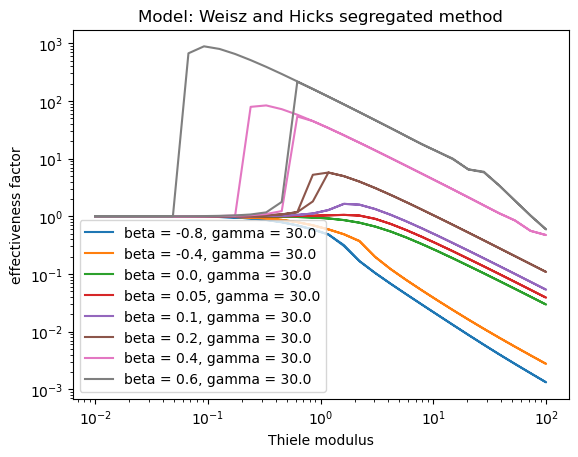

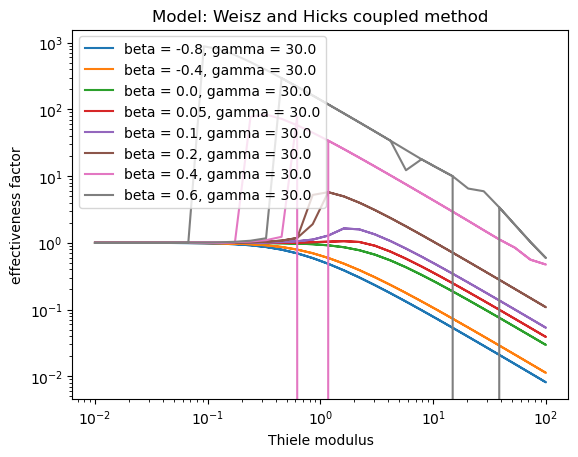

In [12]:
models = [WeiszHicksSegregated, WeiszHicksCoupled]
betas = [-0.8, -0.4, 0.0, 0.05, 0.1, 0.2, 0.4, 0.6]
gamma = 30.0
for model in models:
    for beta in betas:
        mrm_problem = model(0, beta, gamma)
        phis = np.concatenate((np.logspace(-2,2,30), np.logspace(2,-2,30)))
        etas = np.zeros_like(phis)
        for i in range(len(phis)):
            phi = phis[i]
            mrm_problem.set_phi(phi)
            mrm_problem.solve(20)
            etas[i] = mrm_problem.get_apparent_reaction_rate()/(phi*phi)
        plt.loglog(phis, etas, label = f'beta = {beta}, gamma = {gamma}')
    #plt.loglog(phis, 3*(phis/np.tanh(phis)-1)/(phis*phis), color = 'blue', label = r'$\eta = 3(\phi \coth(\phi)-1)/\phi^2$')
    plt.title(f'Model: {mrm_problem.name()}')
    plt.xlabel('Thiele modulus')
    plt.ylabel('effectiveness factor')
    plt.legend()
    plt.show()